<a href="https://colab.research.google.com/github/juniajeff/Deep_Learning_training/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install d2l

In [ ]:
pip install matplotlib==3.3.3

In [ ]:
pip install imgaug==0.2.5

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
pretrained_net = torchvision.models.resnet50(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [ ]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 2048, 10, 15])

In [ ]:
num_classes = 21
net.add_module('final_0', nn.Conv2d(2048, num_classes, kernel_size=1))
net.add_module('UpSample', nn.Upsample(scale_factor=32, mode='bilinear', align_corners=False))
net.add_module('final_1', 
               nn.Sequential(nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)))

In [ ]:
batch_size, crop_size = 5, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


read 1078 examples


In [ ]:
def train_with_scheduler(net, train_iter, test_iter, loss, trainer, scheduler, num_epochs,
               devices=d2l.try_all_gpus()):
    #ch13 from chapter 13
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        scheduler.step()
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

loss 0.445, train acc 0.862, test acc 0.868
9.0 examples/sec on [device(type='cuda', index=0)]


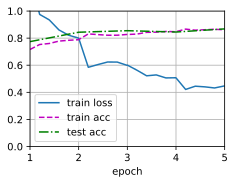

In [ ]:
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CyclicLR(trainer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="triangular") #applying scheduler
train_with_scheduler(net, train_iter, test_iter, loss, trainer, scheduler, num_epochs, devices)

In [ ]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [ ]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

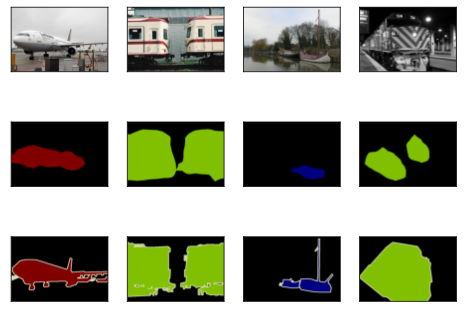

In [ ]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(test_labels[i],
                                               *crop_rect).permute(1, 2, 0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

In [ ]:
import numpy as np 
preds = [imgs[1], imgs[4]]
for p in preds:
    # print(p.shape)
    label = d2l.voc_label_indices(p.permute(2,0,1), d2l.voc_colormap2label())
    u = np.unique(label)
    # print(u, label.shape)
    for n in u:
        print(d2l.VOC_CLASSES[n], end=' ')
    print()

background aeroplane 
background train 


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()